In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import re
from scipy.special import exp1
from scipy.special import expi

In [2]:
plt.rcParams.update({'font.size': 18})

## Method

Our goal is to check theoretical predictions for the moments/cumulants of $P$ vs. simulation results.

Eq. 48 in manuscript gives the MGF of $P$:

$$
\text{MGF}_P=\text{exp}\left(\mu\rho_N\ell_c^2\sum_{k=0}^\infty\varepsilon^k\hat{u}_k(\vec{0},0)\right)
$$

Truncating the sum at the $j$-th term gives the first $j$ moments.

Truncate at $j=2$:
$$
\text{MGF}_P\approx\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)
$$

Note that $\varepsilon$ is defined as follows:
$$\varepsilon=\frac{z}{s\rho_N\ell_c^2}$$

Also note that $\hat{u}_0=0$ and $\hat{u}_1(\vec{0},0)=1$, per methods section.

### First Moment
$$
\begin{align*}
\mathbb{E}[P] &= \frac{d}{dz}\text{MGF}_P\Bigg|_{z=0}\\
&= \frac{d}{d\varepsilon}\frac{d\varepsilon}{dz}\text{MGF}_P\Bigg|_{z=0}\\
&= \frac{d\varepsilon}{dz}\frac{d}{d\varepsilon}\text{MGF}_P\Bigg|_{z=0}\\
&=\frac{1}{s\rho_N\ell_c^2}\left[\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\frac{d}{d\varepsilon}\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\Bigg|_{\varepsilon=0}\right]\\
&=\frac{1}{s\rho_N\ell_c^2}\left[\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)+2\varepsilon\hat{u}_2(\vec{0},0)\right)\Bigg|_{\varepsilon=0}\right]\\
&=\frac{1}{s\rho_N\ell_c^2}\left[\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)\right)\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)\right)\right)\right]\\
&=\frac{\mu}{s}\hat{u}_1(\vec{0},0)\cdot\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)\right)\right)\\
&=\frac{\mu}{s}
\end{align*}
$$

### Second Moment

$$
\begin{align}
\mathbb{E}[P^2]&=\frac{d^2}{dz^2}\text{MGF}_P\Bigg|_{z=0}\\
&=\frac{d^2}{d\varepsilon^2}\frac{d\varepsilon^2}{dz^2}\text{MGF}_P\Bigg|_{z=0}\\
&=\frac{d\varepsilon^2}{dz^2}\frac{d^2}{d\varepsilon^2}\text{MGF}_P\Bigg|_{z=0}\\
&=\left(\frac{1}{s\rho_N\ell_c^2}\right)^2\left[\frac{d}{d\varepsilon}\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)+2\varepsilon\hat{u}_2(\vec{0},0)\right)\Bigg|_{\varepsilon=0}\right]\\
&=\left(\frac{1}{s\rho_N\ell_c^2}\right)^2\left[\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\left[\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)+2\varepsilon\hat{u}_2(\vec{0},0)\right)\right]^2+2\mu\rho_N\ell_c^2\hat{u}_2(\vec{0},0)\cdot\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\Bigg|_{\varepsilon=0}\right]\\
&=\left(\frac{1}{s\rho_N\ell_c^2}\right)^2\left[\text{exp}\left(\mu\rho_N\ell_c^2\hat{u}_0(\vec{0},0)\right)\cdot\left(\mu\rho_N\ell_c^2\hat{u}_1(\vec{0},0)\right)^2+2\mu\rho_N\ell_c^2\hat{u}_2(\vec{0},0)\cdot\text{exp}\left(\mu\rho_N\ell_c^2\hat{u}_0(\vec{0},0)\right)\right]\\
&=\left(\frac{\mu}{s}\right)^2+\frac{2\mu}{s^2\rho_N\ell_c^2}\hat{u}_2(\vec{0},0)
\end{align}
$$

To summarize:

$$\mathbb{E}[P]=\frac{\mu}{s}$$

$$\mathbb{E}[P^2]=\left(\frac{\mu}{s}\right)^2+\frac{2\mu}{s^2\rho_N\ell_c^2}\hat{u}_2(\vec{0},0)$$

## Compare moments from theory & simulation (numerical values for $\hat{u}_2$)

In [3]:
### functions

def get_lc_squared(sigma,s):
    return sigma**2/s

def get_EP(mu,s):
    return mu/s

def get_EPsquared(mu,s,rho,sigma,u2):
    return (mu/s)**2 +((2*mu)/((s**2)*rho*get_lc_squared(sigma,s)))*u2

def get_closest_index(df,w):
    diff = abs(df['w']-w)
    return diff.idxmin()

def get_mean_count(sfs):
    mean = sum(x * p for x, p in enumerate(sfs))
    return mean

In [4]:
def get_moments(files,spatial_integrals_file):
    spatial_integrals = pd.read_csv(spatial_integrals_file)
    res = np.zeros((len(files),10))
    for i,f in enumerate(files):
        matches = re.match(r'.*/s([\d.]+)_n(\d+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_maxcount(\d+)_sigma([\d.]+)_seed(\d+)_iter(\d+)_r([\d.]+)_gaussian_w(\d+)\.sfs',f)
        s, n, mu, rho, L, maxcount, sigma, seed, iteration, r, w = matches.groups()
        s = float(s)
        mu = float(mu)
        rho = int(rho)
        sigma = float(sigma)
        w = float(w)
        w_tilde = w/np.sqrt(get_lc_squared(sigma,s))
        theory_u2 = spatial_integrals.iloc[get_closest_index(spatial_integrals,w_tilde),1]
        sim_data = pd.read_csv(f,header=None)
        res[i,:] = [s,mu,rho,sigma,get_EP(mu,s),get_EPsquared(mu,s,rho,sigma,theory_u2),sim_data.iloc[0,0],sim_data.iloc[1,0],sim_data.iloc[2,0],get_mean_count(sim_data[0].tolist())]

    res = pd.DataFrame(res,columns=['s','mu','rho','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2','mean_count'])
    res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
    res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_meancount'] = 2*res['theory_firstmoment']
    
    return res
    
def plot_moments(files,spatial_integrals_file,title="Moments: sim vs theory"):
    res = get_moments(files,spatial_integrals_file)
    unique_rho_values = sorted(res['rho'].unique())
    unique_mu_values = sorted(res['mu'].unique())
    colors = ['red','blue','green']
    color_dict = dict(zip(unique_rho_values, colors))
    marker_shapes = ["^",'+','x']
    
    fig,axs = plt.subplots(2,2,figsize=(24,24))
    legend_handles = []
    for i, rho_value in enumerate(sorted(res['rho'].unique())):
        for mu_value in unique_mu_values:
            res_rho_mu = res[(res['rho'] == rho_value) & (res['mu'] == mu_value)]
            for j, s_value in enumerate(sorted(res['s'].unique())):
                res_s = res_rho_mu[res_rho_mu['s'] == s_value]
                marker_size = 1000/(-np.log10(mu_value))
                if mu_value == 1e-7:
                    label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value)
                else:
                    label = ""
                axs[0,0].scatter(res_s['theory_xi0'], res_s['xi0'], color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[0,1].scatter(res_s['theory_meancount'],res_s['mean_count'],color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[1,0].scatter(res_s['theory_xi1'], res_s['xi1'], color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[1,1].scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                
    axs[0,0].plot(np.logspace(np.log10(0.8),np.log10(2.2)),np.logspace(np.log10(0.8),np.log10(2.2)),color='black')
    axs[0,0].set_xlabel("theory")
    axs[0,0].set_ylabel("simulation")
    axs[0,0].legend()
    axs[0,0].set_title(r"$\mathbb{E}[(1-P)^2]$")

    axs[0,1].plot(np.logspace(-7,0),np.logspace(-7,0),color='black')
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[0,1].set_xlabel("theory")
    axs[0,1].set_ylabel("simulation")
    axs[0,1].legend()
    axs[0,1].set_title(r"$\mathbb{E}[2P]$")

    axs[1,0].plot(np.logspace(-8,0),np.logspace(-8,0),color='black')
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].legend()
    axs[1,0].set_title(r"$\mathbb{E}[2P(1-P)]$")
    
    axs[1,1].plot(np.logspace(-9,0),np.logspace(-9,0),color='black')
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    axs[1,1].legend()
    axs[1,1].set_title(r"$\mathbb{E}[P^2]$")
    
    fig.suptitle(title,y=0.9)
    plt.show()
#     return res

**Theory vs. simulation with numerically calculated $\hat{u}_2$**

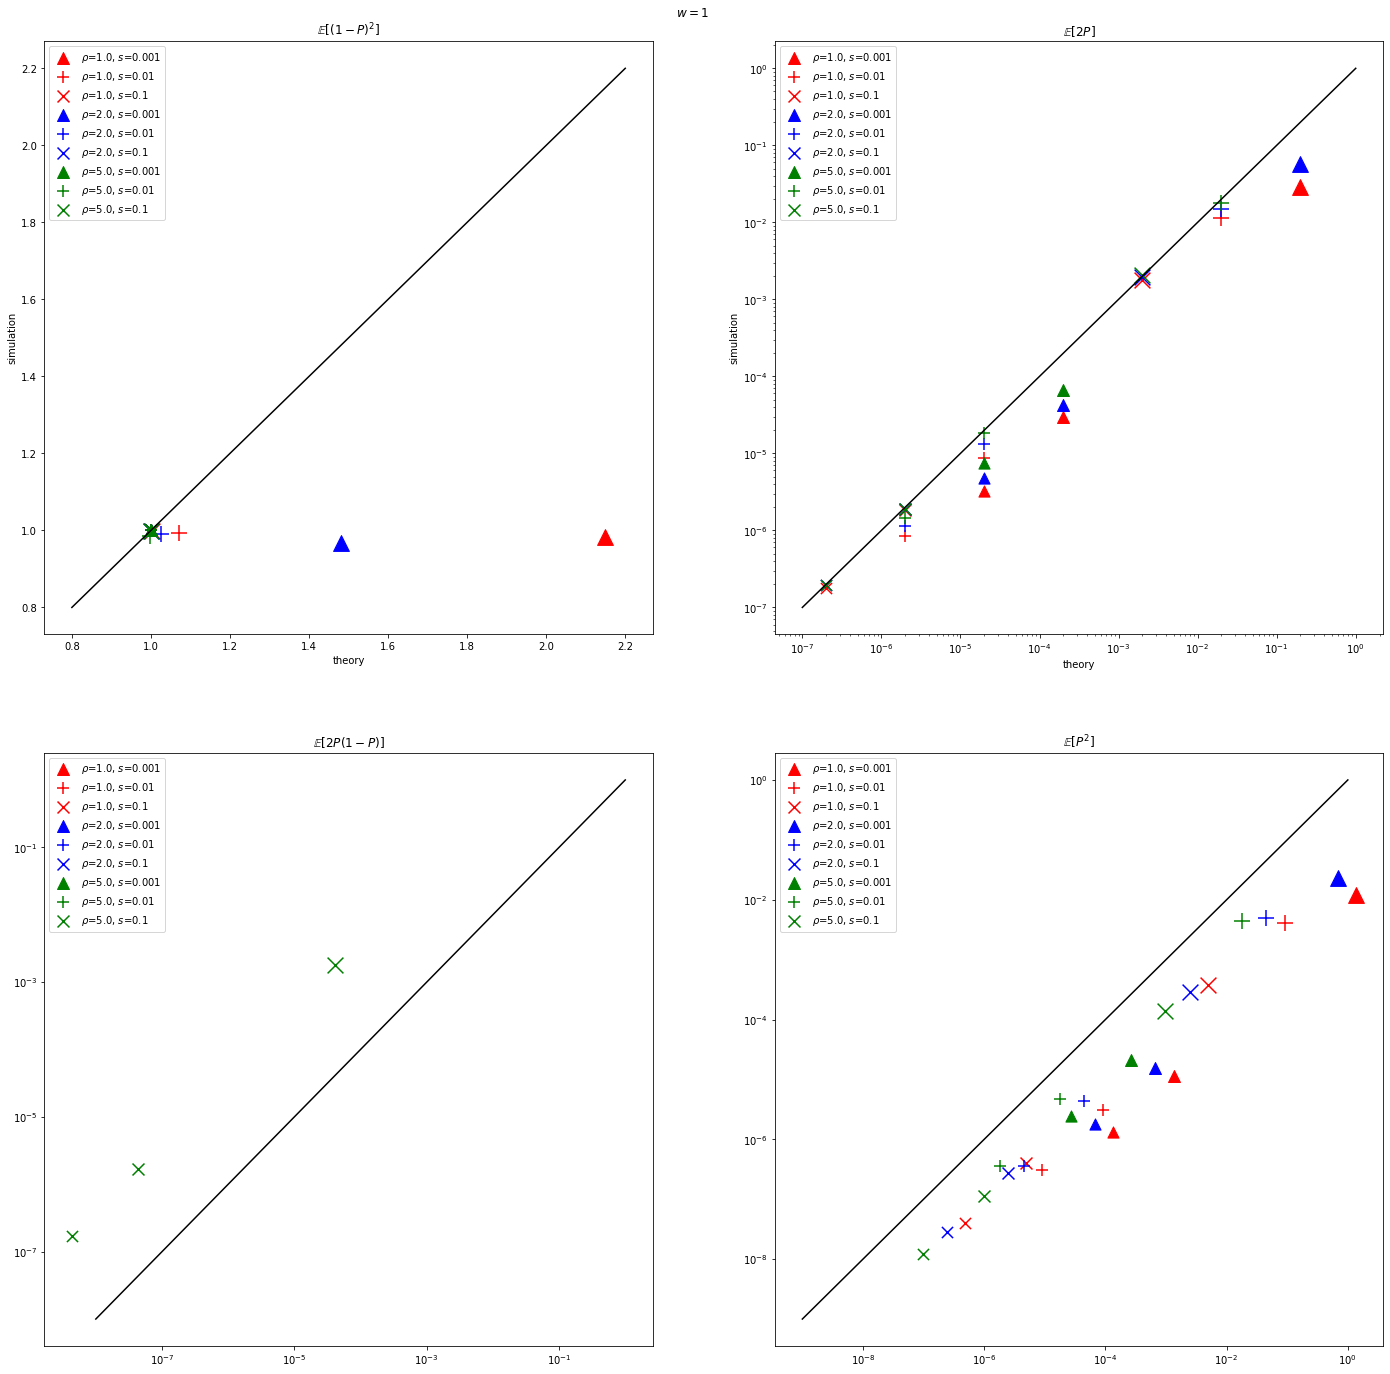

In [5]:
files_w1 = glob.glob("../results/gaussian_w1/*_n2_*_L50_*_iter100000000*.sfs")
plot_moments(files_w1,"../../theory/old_files/results/spatial_integrals_dim2.csv",r"$w=1$")

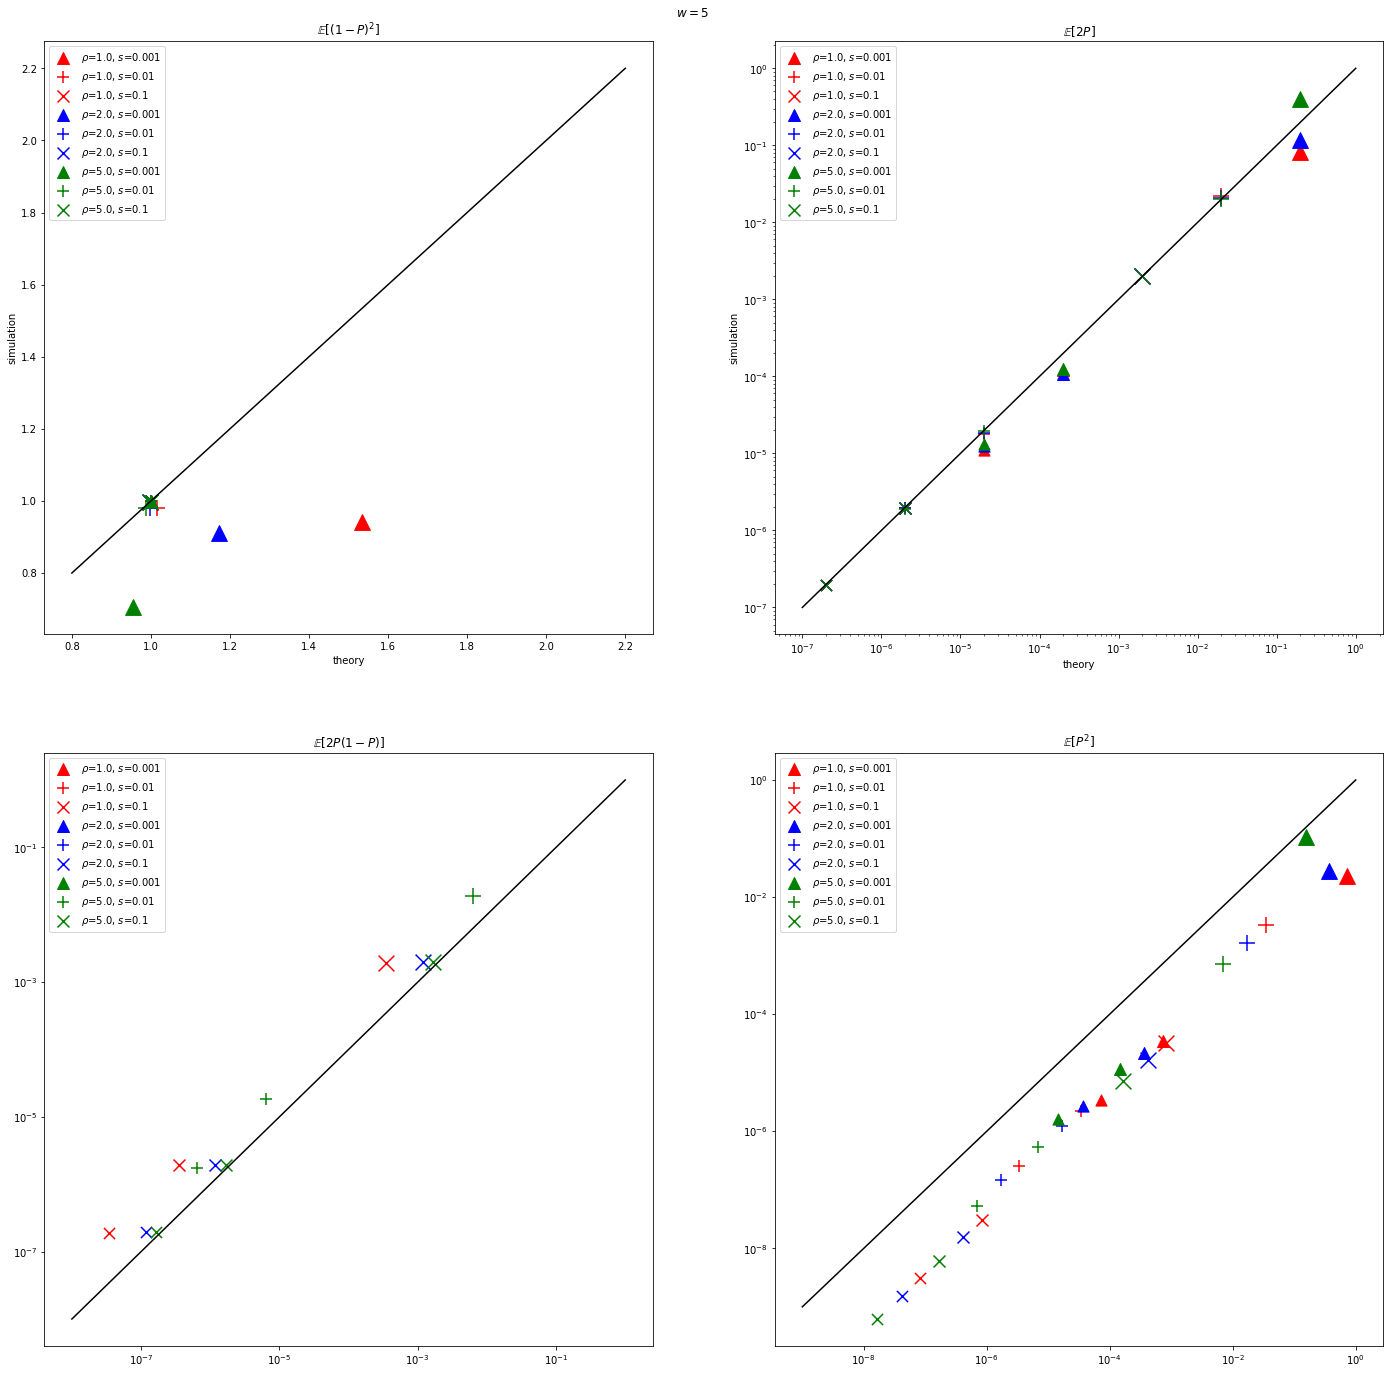

In [6]:
files_w5 = glob.glob("../results/gaussian_w5/*_n2_*_L50_*_iter100000000*.sfs")
plot_moments(files_w5,"../../theory/old_files/results/spatial_integrals_dim2.csv",r"$w=5$")

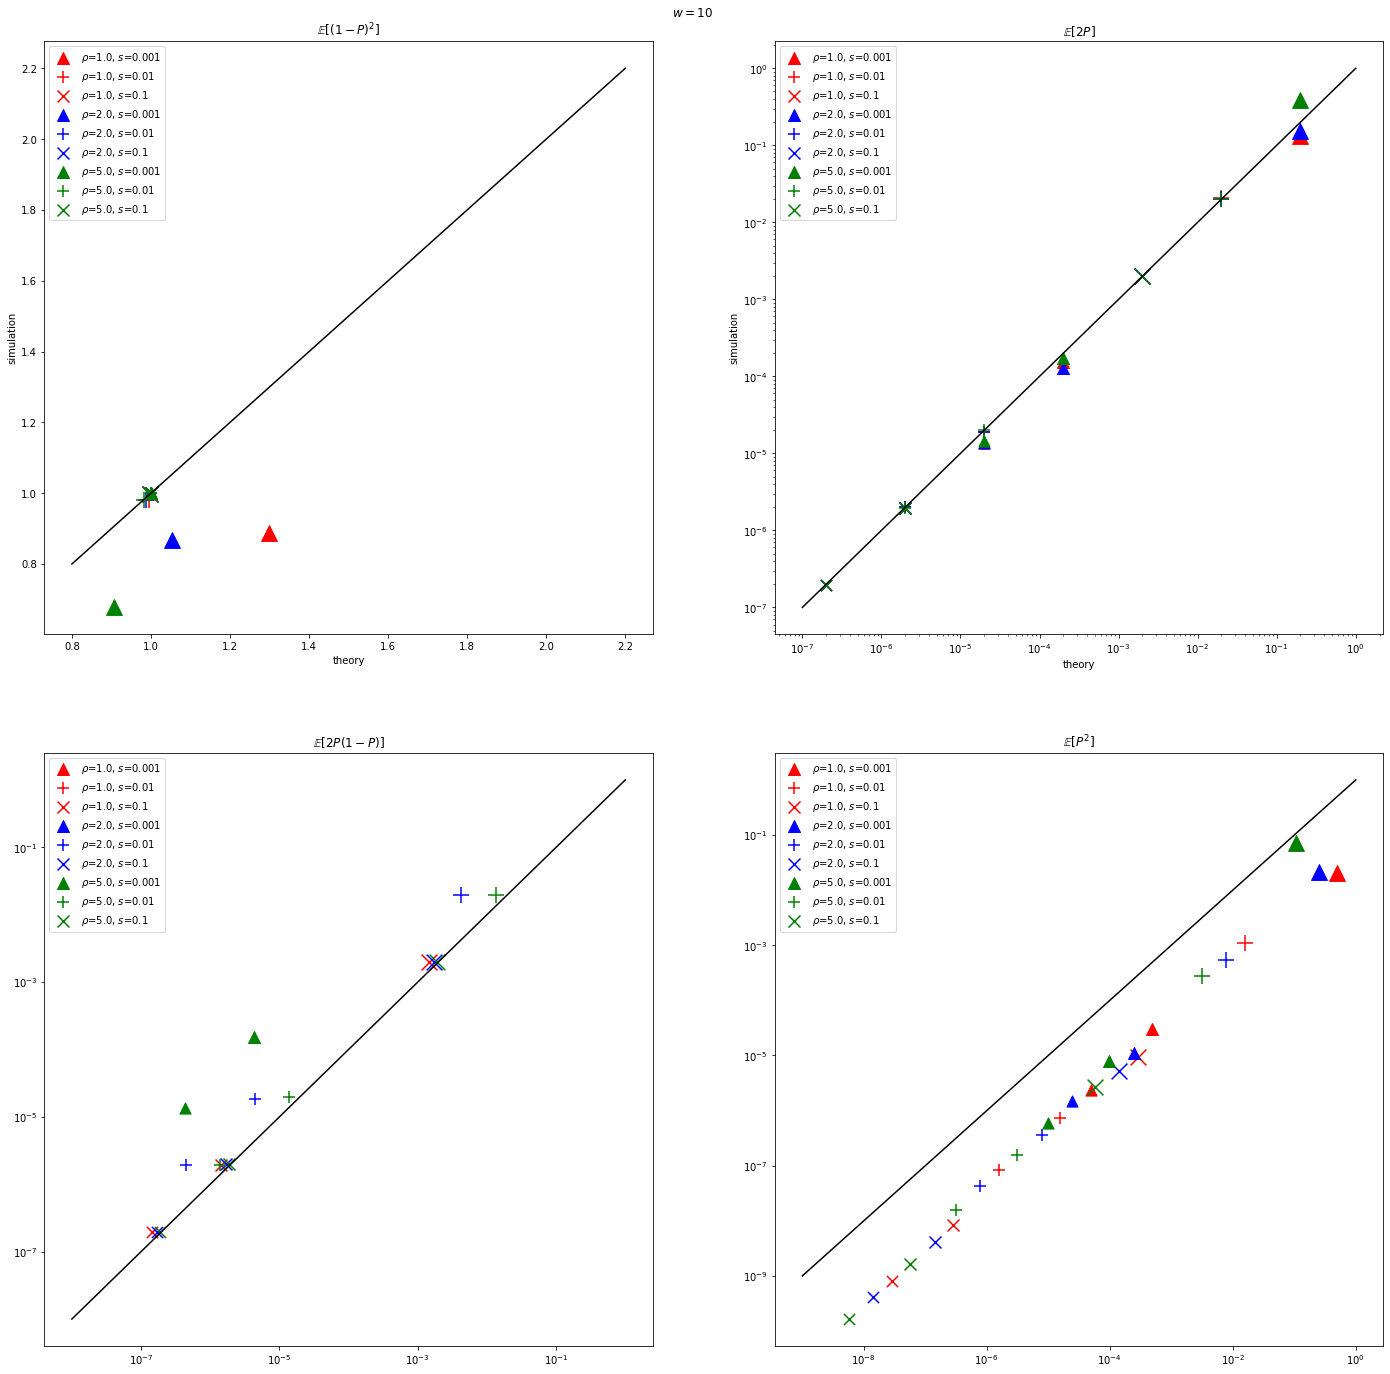

In [7]:
files_w10 = glob.glob("../results/gaussian_w10/*_n2_*_L50_*_iter100000000*.sfs")
plot_moments(files_w10,"../../theory/old_files/results/spatial_integrals_dim2.csv",r"$w=10$")

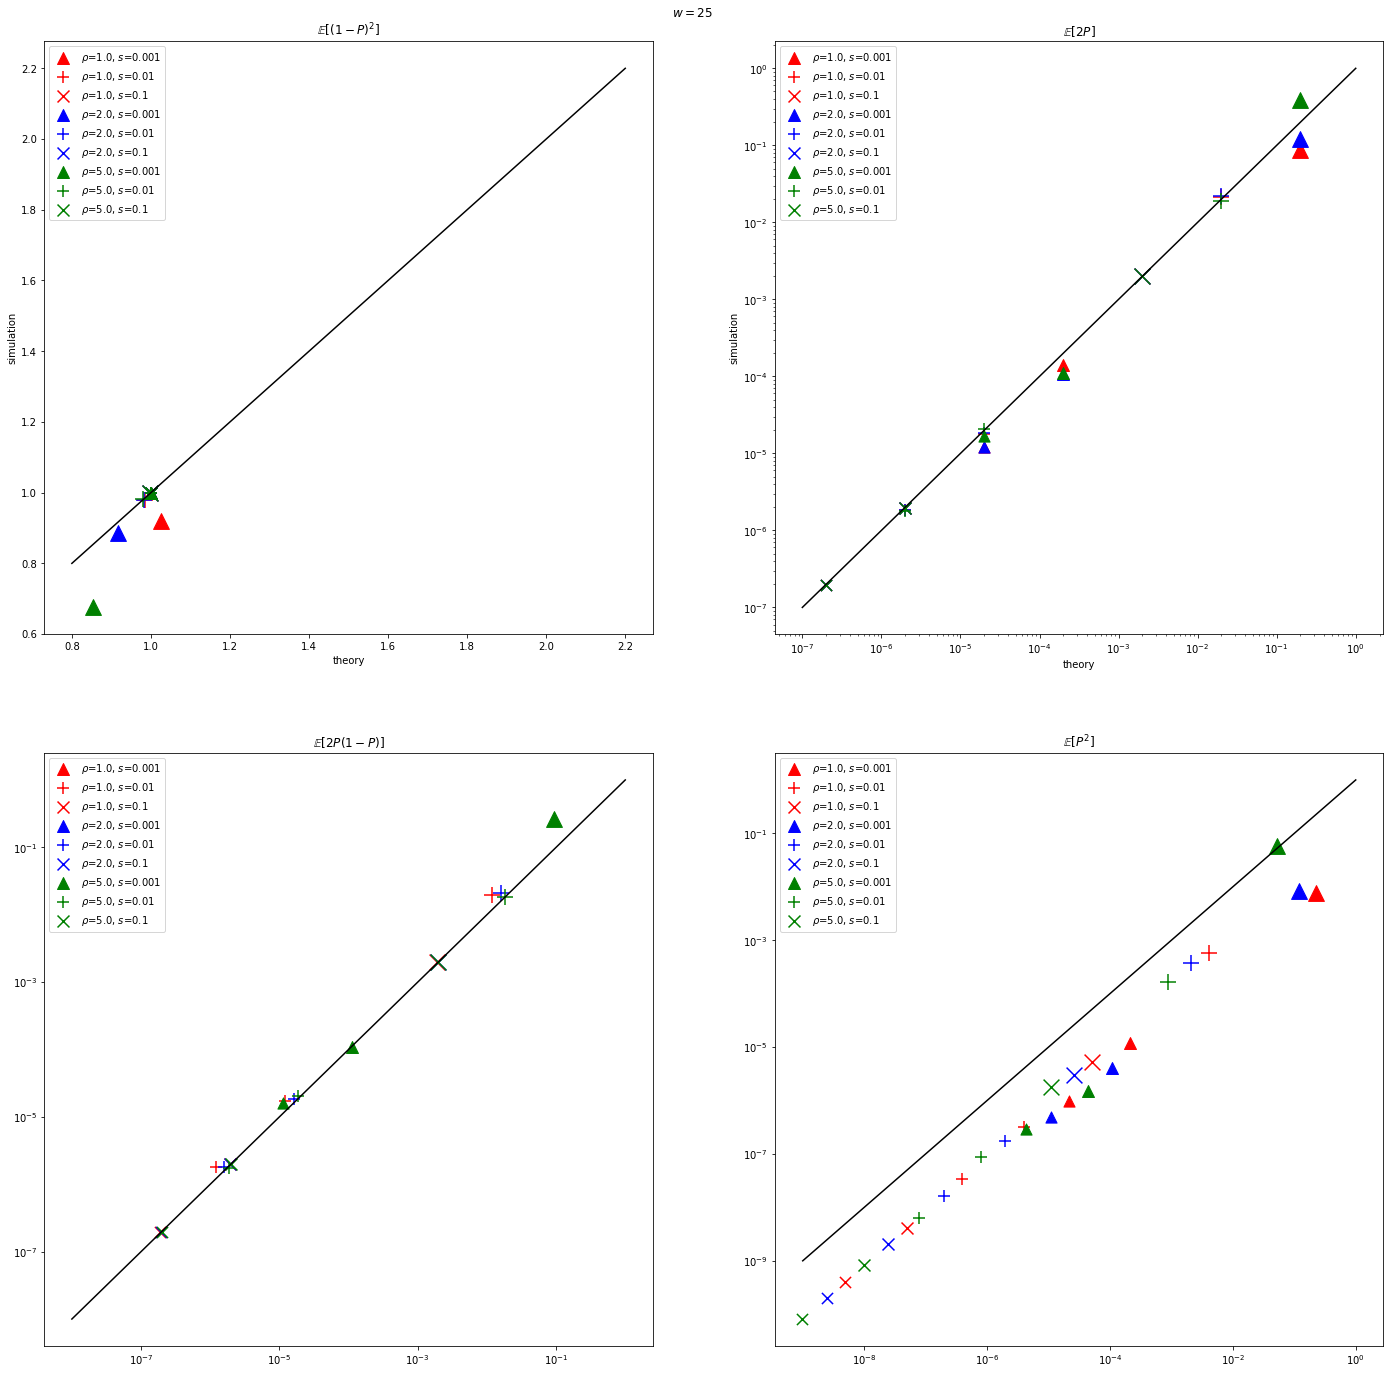

In [8]:
files_w25 = glob.glob("../results/gaussian_w25/*_n2_*_L50_*_iter10000000*.sfs")
plot_moments(files_w25,"../../theory/old_files/results/spatial_integrals_dim2.csv",r"$w=25$")

*Note:* All are 100M iterations except for w=25 (10M iterations)

## Compare $\hat{u}_2$ from numerical integration vs. special functions (exact) form

The value of $\hat{u}_2(\vec{0},0)$ can be written exactly using special functions:
$$\hat{u}_2(\vec{0},0)=e^{\tilde{w}^2 / (2 \pi)} E_1(\tilde{w}^2 / (2 \pi)) / 4$$

In [9]:
def u2_exact(w):
    return (-1*np.exp(w**2/(4*np.pi**2))/(8*np.pi))*expi(-1*w**2/(4*np.pi**2))
    #return np.exp(w**2/(2*np.pi))*exp1(w**2/(2*np.pi))/4

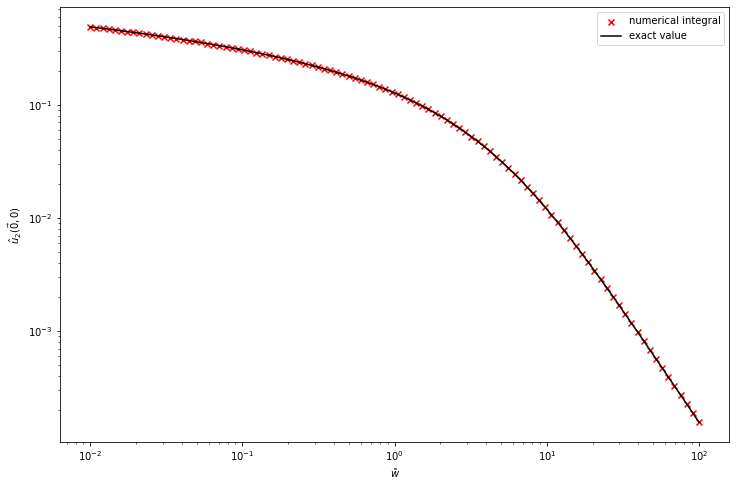

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
spatial_integrals = pd.read_csv('../../theory/old_files/results/spatial_integrals_dim2.csv')
exact_vals = [u2_exact(w) for w in spatial_integrals['w']]
ax.scatter(spatial_integrals['w'],spatial_integrals['u2_GQ'],marker='x',color='red',label='numerical integral')
ax.plot(spatial_integrals['w'],exact_vals,marker=None,color='black',label='exact value')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\tilde{w}$')
ax.set_ylabel(r'$\hat{u}_2(\vec{0},0)$')
ax.legend()
plt.show()

Now try comparisons to theory again...

In [11]:
def get_moments_v2(files):
    res = np.zeros((len(files),10))
    for i,f in enumerate(files):
        matches = re.match(r'.*/s([\d.]+)_n(\d+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_maxcount(\d+)_sigma([\d.]+)_seed(\d+)_iter(\d+)_r([\d.]+)_gaussian_w(\d+)\.sfs',f)
        s, n, mu, rho, L, maxcount, sigma, seed, iteration, r, w = matches.groups()
        s = float(s)
        mu = float(mu)
        rho = int(rho)
        sigma = float(sigma)
        w = float(w)
        w_tilde = w/np.sqrt(get_lc_squared(sigma,s))
        theory_u2 = u2_exact(w_tilde)
        sim_data = pd.read_csv(f,header=None)
        res[i,:] = [s,mu,rho,sigma,get_EP(mu,s),get_EPsquared(mu,s,rho,sigma,theory_u2),sim_data.iloc[0,0],sim_data.iloc[1,0],sim_data.iloc[2,0],get_mean_count(sim_data[0].tolist())]

    res = pd.DataFrame(res,columns=['s','mu','rho','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2','mean_count'])
    res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
    res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_meancount'] = 2*res['theory_firstmoment']
    
    return res
    
def plot_moments_v2(files,title="Moments: sim vs theory"):
    res = get_moments_v2(files)
    unique_rho_values = sorted(res['rho'].unique())
    unique_mu_values = sorted(res['mu'].unique())
    colors = ['red','blue','green']
    color_dict = dict(zip(unique_rho_values, colors))
    marker_shapes = ["^",'+','x']
    
    fig,axs = plt.subplots(2,2,figsize=(24,24))
    legend_handles = []
    for i, rho_value in enumerate(sorted(res['rho'].unique())):
        for mu_value in unique_mu_values:
            res_rho_mu = res[(res['rho'] == rho_value) & (res['mu'] == mu_value)]
            for j, s_value in enumerate(sorted(res['s'].unique())):
                res_s = res_rho_mu[res_rho_mu['s'] == s_value]
                marker_size = 1000/(-np.log10(mu_value))
                if mu_value == 1e-7:
                    label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value)
                else:
                    label = ""
                axs[0,0].scatter(res_s['theory_xi0'], res_s['xi0'], color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[0,1].scatter(res_s['theory_meancount'],res_s['mean_count'],color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[1,0].scatter(res_s['theory_xi1'], res_s['xi1'], color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[1,1].scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[rho_value], label=label, marker=marker_shapes[j], s=marker_size)
                
    axs[0,0].plot(np.logspace(np.log10(0.8),np.log10(2.2)),np.logspace(np.log10(0.8),np.log10(2.2)),color='black')
    axs[0,0].set_xlabel("theory")
    axs[0,0].set_ylabel("simulation")
    axs[0,0].legend()
    axs[0,0].set_title(r"$\mathbb{E}[(1-P)^2]$")

    axs[0,1].plot(np.logspace(-7,0),np.logspace(-7,0),color='black')
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[0,1].set_xlabel("theory")
    axs[0,1].set_ylabel("simulation")
    axs[0,1].legend()
    axs[0,1].set_title(r"$\mathbb{E}[2P]$")

    axs[1,0].plot(np.logspace(-8,0),np.logspace(-8,0),color='black')
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].legend()
    axs[1,0].set_title(r"$\mathbb{E}[2P(1-P)]$")
    
    axs[1,1].plot(np.logspace(-9,0),np.logspace(-9,0),color='black')
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    axs[1,1].legend()
    axs[1,1].set_title(r"$\mathbb{E}[P^2]$")
    
    fig.suptitle(title,y=0.9)
    plt.show()
#     return res

**Using "exact" version of $\hat{u}_2$...**

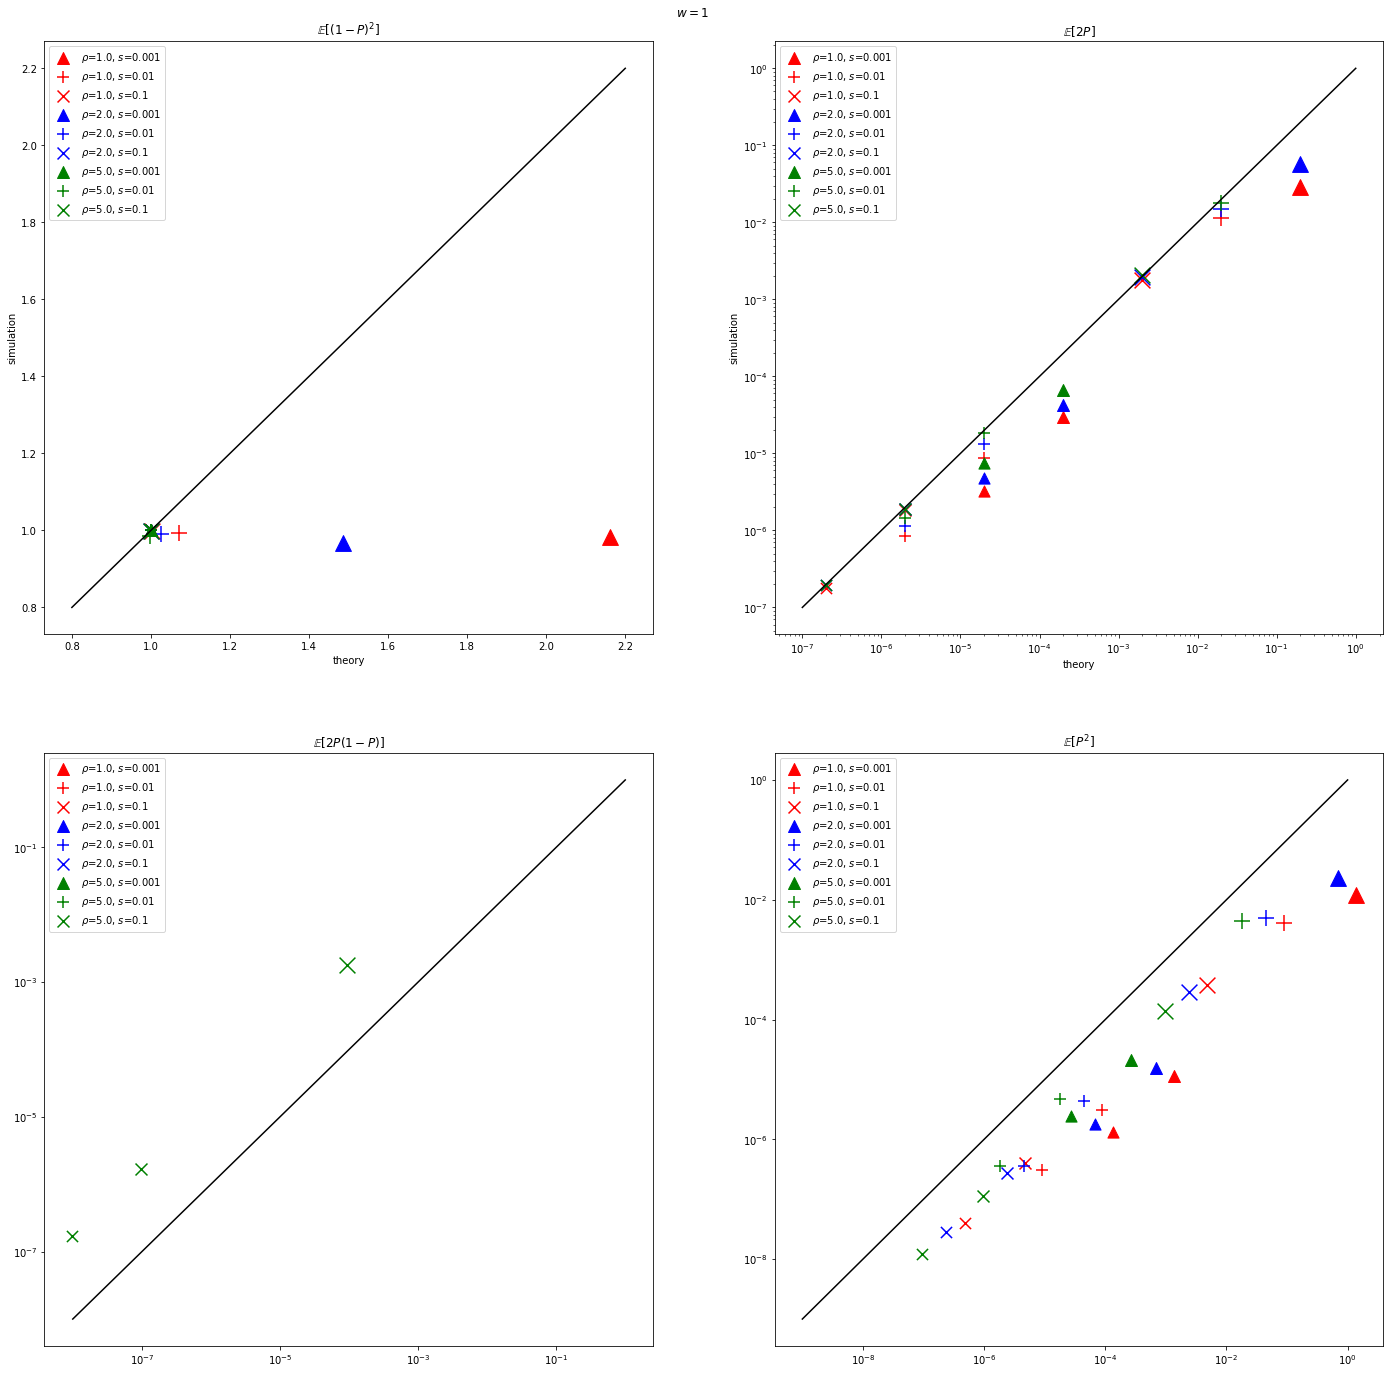

In [12]:
plot_moments_v2(files_w1,r"$w=1$")

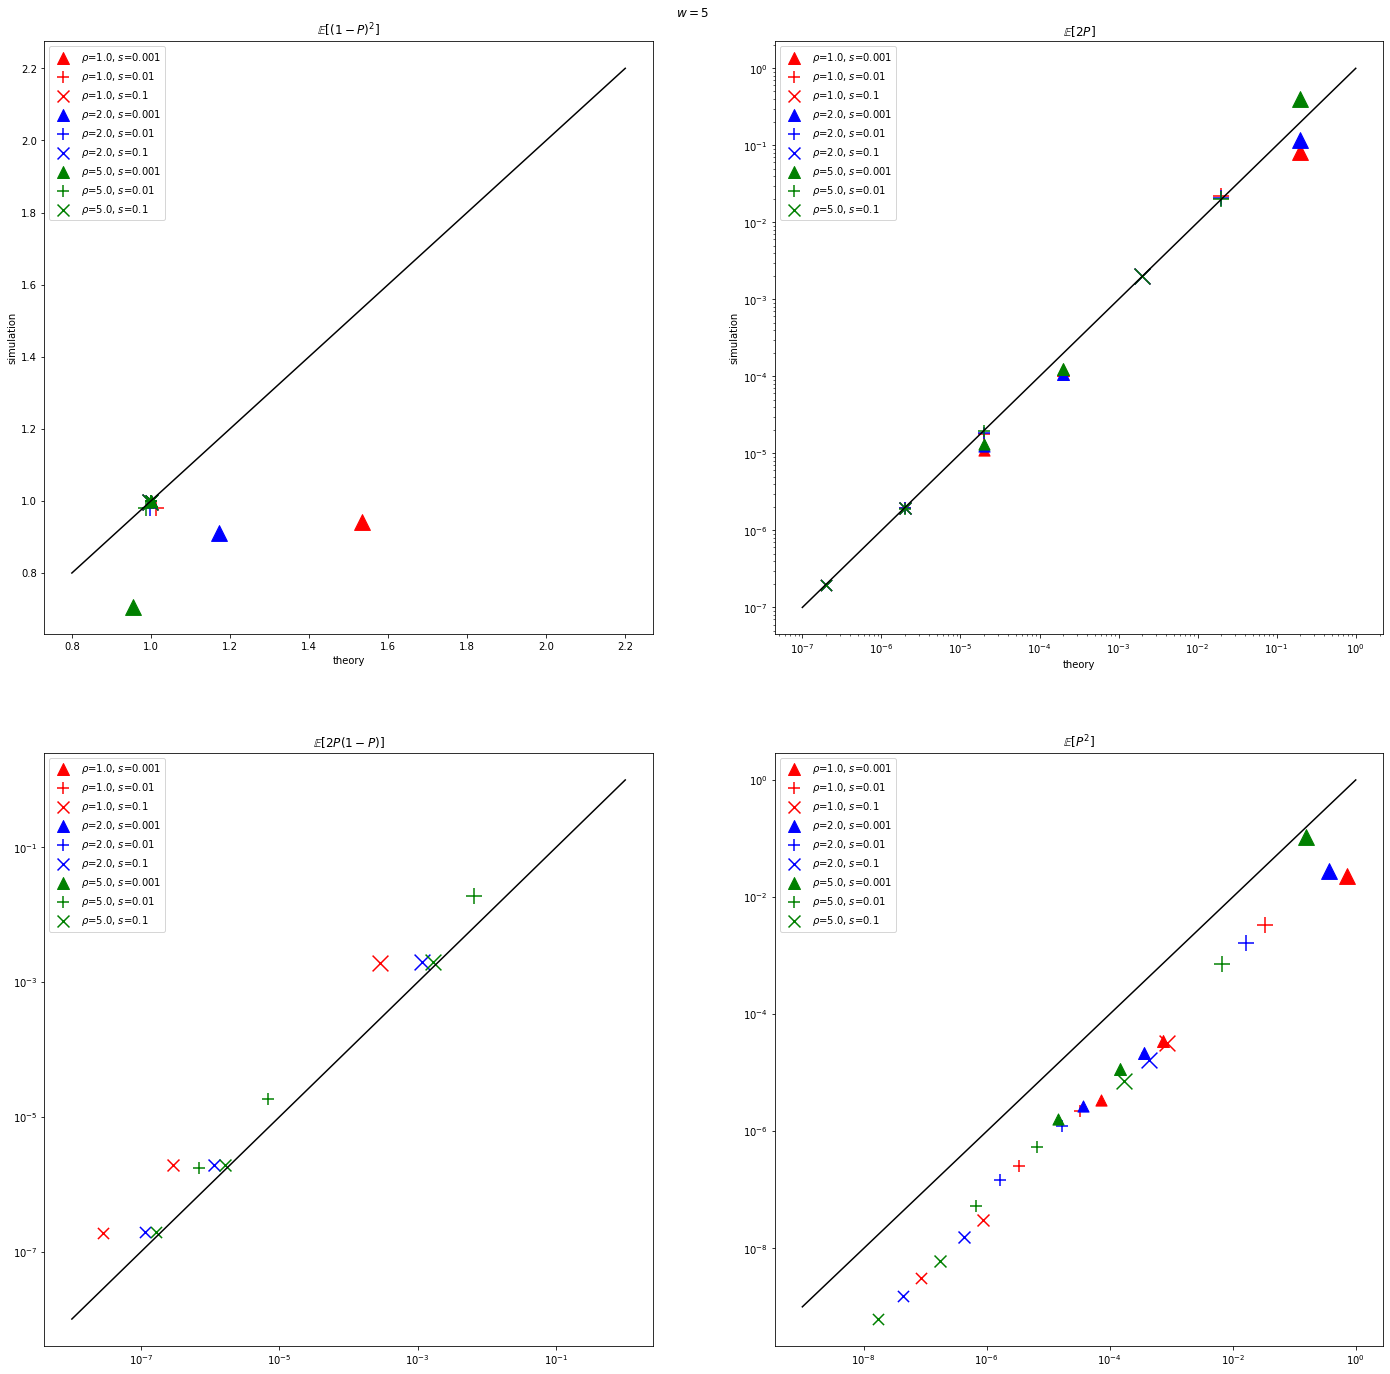

In [13]:
plot_moments_v2(files_w5,r"$w=5$")

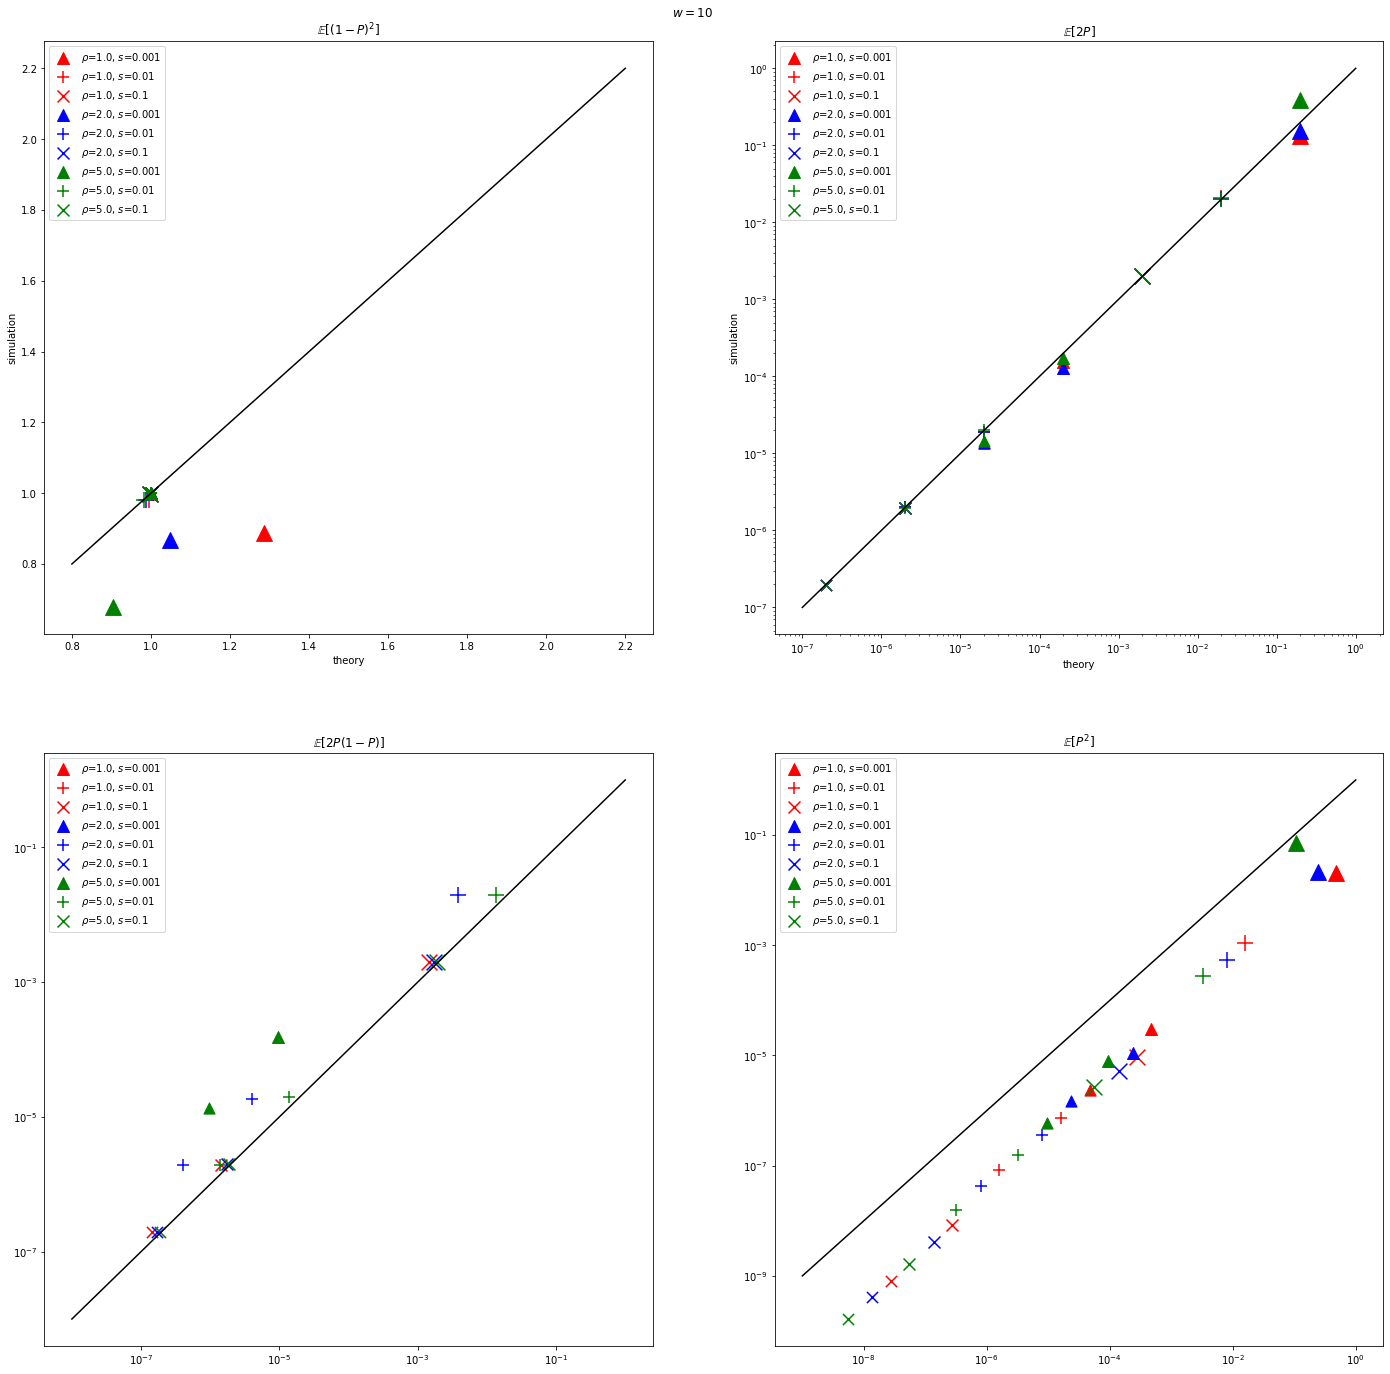

In [14]:
plot_moments_v2(files_w10,r"$w=10$")

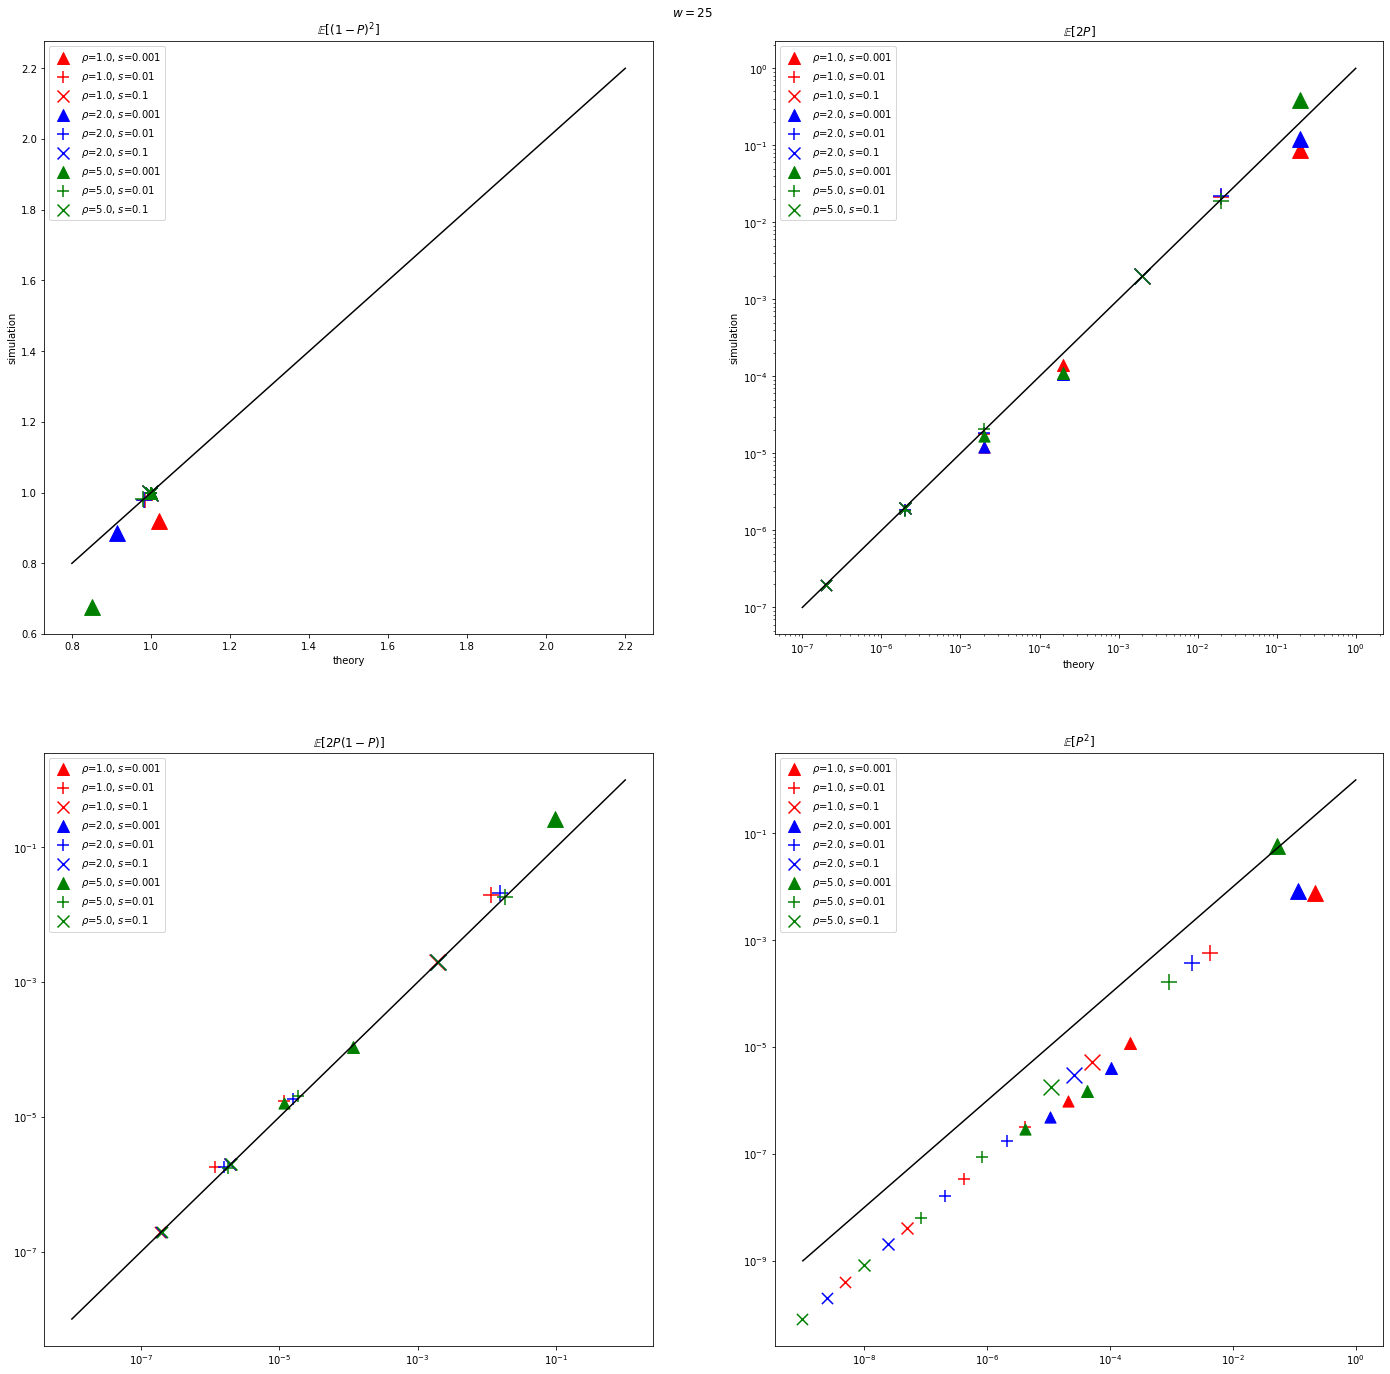

In [15]:
plot_moments_v2(files_w25,r"$w=25$")

**Note that in both versions we get values for $\xi_1$ that are negative...**

In [16]:
get_moments(files_w1,'../../theory/old_files/results/spatial_integrals_dim2.csv')

,s,mu,rho,sigma,theory_firstmoment,theory_secondmoment,xi0,xi1,xi2,mean_count,theory_xi0,theory_xi1,theory_xi2,theory_meancount
0,0.010,1.000000e-08,5.0,0.2,1.000000e-06,1.801888e-06,0.999999,7.449783e-07,3.558168e-07,1.456612e-06,1.000000,-1.603775e-06,1.801888e-06,2.000000e-06
1,0.100,1.000000e-07,5.0,0.2,1.000000e-06,9.782662e-07,0.999998,1.675349e-06,1.139805e-07,1.903310e-06,0.999999,4.346769e-08,9.782662e-07,2.000000e-06
2,0.100,1.000000e-04,2.0,0.2,1.000000e-03,2.446663e-03,0.998341,1.367683e-03,2.911838e-04,1.950051e-03,1.000447,-2.893326e-03,2.446663e-03,2.000000e-03
3,0.001,1.000000e-08,1.0,0.2,1.000000e-05,1.339301e-04,0.999998,6.467723e-07,1.307320e-06,3.261411e-06,1.000114,-2.478602e-04,1.339301e-04,2.000000e-05
4,0.100,1.000000e-07,1.0,0.2,1.000000e-06,4.891327e-06,0.999999,1.024043e-06,3.964667e-07,1.816976e-06,1.000003,-7.782654e-06,4.891327e-06,2.000000e-06
5,0.010,1.000000e-08,1.0,0.2,1.000000e-06,9.009435e-06,0.999999,2.516710e-07,3.027539e-07,8.571789e-07,1.000007,-1.601887e-05,9.009435e-06,2.000000e-06
6,0.010,1.000000e-04,2.0,0.2,1.000000e-02,4.514717e-02,0.990048,5.067435e-03,4.884146e-03,1.483573e-02,1.025147,-7.029434e-02,4.514717e-02,2.000000e-02
7,0.001,1.000000e-08,5.0,0.2,1.000000e-05,2.678610e-05,0.999995,2.546314e-06,2.498149e-06,7.542613e-06,1.000007,-3.357219e-05,2.678610e-05,2.000000e-05
8,0.001,1.000000e-07,5.0,0.2,1.000000e-04,2.678700e-04,0.999954,2.495953e-05,2.108399e-05,6.712751e-05,1.000068,-3.357399e-04,2.678700e-04,2.000000e-04
9,0.010,1.000000e-07,1.0,0.2,1.000000e-05,9.009444e-05,0.999994,2.490979e-06,3.117411e-06,8.725801e-06,1.000070,-1.601889e-04,9.009444e-05,2.000000e-05


In [17]:
get_moments_v2(files_w1)

,s,mu,rho,sigma,theory_firstmoment,theory_secondmoment,xi0,xi1,xi2,mean_count,theory_xi0,theory_xi1,theory_xi2,theory_meancount
0,0.010,1.000000e-08,5.0,0.2,1.000000e-06,1.798327e-06,0.999999,7.449783e-07,3.558168e-07,1.456612e-06,1.000000,-1.596654e-06,1.798327e-06,2.000000e-06
1,0.100,1.000000e-07,5.0,0.2,1.000000e-06,9.514778e-07,0.999998,1.675349e-06,1.139805e-07,1.903310e-06,0.999999,9.704445e-08,9.514778e-07,2.000000e-06
2,0.100,1.000000e-04,2.0,0.2,1.000000e-03,2.379692e-03,0.998341,1.367683e-03,2.911838e-04,1.950051e-03,1.000380,-2.759384e-03,2.379692e-03,2.000000e-03
3,0.001,1.000000e-08,1.0,0.2,1.000000e-05,1.351296e-04,0.999998,6.467723e-07,1.307320e-06,3.261411e-06,1.000115,-2.502593e-04,1.351296e-04,2.000000e-05
4,0.100,1.000000e-07,1.0,0.2,1.000000e-06,4.757385e-06,0.999999,1.024043e-06,3.964667e-07,1.816976e-06,1.000003,-7.514770e-06,4.757385e-06,2.000000e-06
5,0.010,1.000000e-08,1.0,0.2,1.000000e-06,8.991631e-06,0.999999,2.516710e-07,3.027539e-07,8.571789e-07,1.000007,-1.598326e-05,8.991631e-06,2.000000e-06
6,0.010,1.000000e-04,2.0,0.2,1.000000e-02,4.505815e-02,0.990048,5.067435e-03,4.884146e-03,1.483573e-02,1.025058,-7.011630e-02,4.505815e-02,2.000000e-02
7,0.001,1.000000e-08,5.0,0.2,1.000000e-05,2.702601e-05,0.999995,2.546314e-06,2.498149e-06,7.542613e-06,1.000007,-3.405201e-05,2.702601e-05,2.000000e-05
8,0.001,1.000000e-07,5.0,0.2,1.000000e-04,2.702691e-04,0.999954,2.495953e-05,2.108399e-05,6.712751e-05,1.000070,-3.405381e-04,2.702691e-04,2.000000e-04
9,0.010,1.000000e-07,1.0,0.2,1.000000e-05,8.991640e-05,0.999994,2.490979e-06,3.117411e-06,8.725801e-06,1.000070,-1.598328e-04,8.991640e-05,2.000000e-05


## Compare $w$ vs. $\tilde{w}$

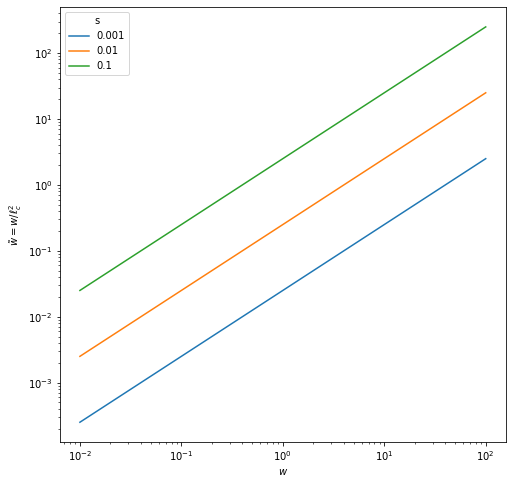

In [18]:
w_vals = np.logspace(-2,2)
s_vals = [1e-3,1e-2,1e-1]

fig,ax = plt.subplots(figsize=(8,8))

for s in s_vals:
    w_tilde_vals = [w/get_lc_squared(0.2,s) for w in w_vals]
    ax.plot(w_vals,w_tilde_vals,label=str(s))
    
ax.legend(title="s")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$w$")
ax.set_ylabel(r"$\tilde{w}=w/\ell_c^2$")
plt.show()